# Kaggle Dataset Loading

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset

kaggle-cat-vs-dog-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip kaggle-cat-vs-dog-dataset.zip

Archive:  kaggle-cat-vs-dog-dataset.zip
replace kagglecatsanddogs_3367a/MSR-LA - 3467.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data preprocessing

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, ReLU, LeakyReLU, BatchNormalization, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16

In [41]:
path_to_cats = '/content/kagglecatsanddogs_3367a/PetImages/Cat/'
path_to_dogs = '/content/kagglecatsanddogs_3367a/PetImages/Dog/'
features = []
labels = []
size = (128, 128)
# image size is (270, 356, 3)

In [24]:
def data_preprocessing(folder, label, data_size):
    files = os.listdir(folder) #files now  contains all the images found in'folder'
    count = 0
    for file in files:
        if count <= data_size:
            img = cv2.imread(folder+file)
            if img is not None: # if the file is not empty
                img = cv2.resize(img, dsize = size)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # img_reflected = cv2.flip(img, 1)
                features.append(img)
                # features.append(img_reflected)
                labels.append(label)
                # labels.append(label)
        else: break
        count += 1


In [25]:
data_preprocessing(path_to_cats, 0, 1000)
data_preprocessing(path_to_dogs, 1, 1000)

In [26]:
features_np = np.array(features).astype(np.float32)
labels_np = np.array(labels).astype(np.float32)

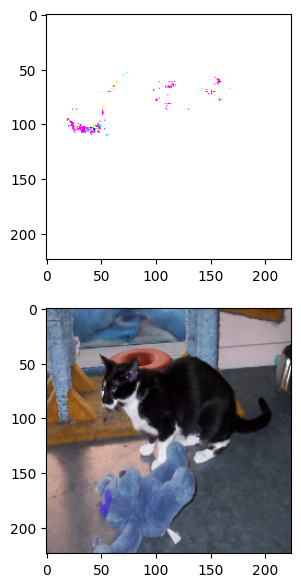

In [27]:
# features_np = features_np/255
# plt.imshow(features_np[0])
rows = 2
col = 1

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(rows, col, 1)
plt.imshow(features_np[0])

fig.add_subplot(rows, col, 2)
plt.imshow(cv2.flip(features[0], 1))

(1600, 224, 224, 3)
(1600,)


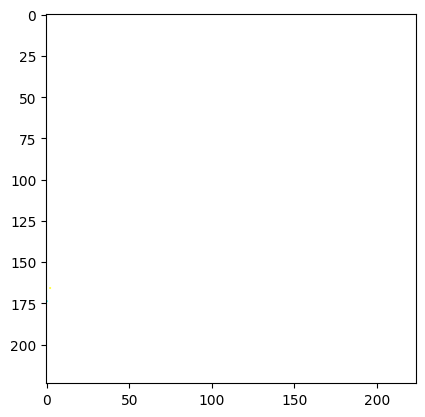

In [28]:
train_features, test_features, train_labels, test_labels = train_test_split(features_np, labels_np, test_size=0.20, shuffle=True)


plt.imshow(train_features[1])

print(train_features.shape)
print(train_labels.shape)

In [31]:
# generator dimensions
width, height, channels = 224, 224, 3

features_gen_train = train_features.reshape((train_features.shape[0], width, height, channels))
features_gen_test = test_features.reshape((test_features.shape[0], width, height, channels))
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

datagen.fit(features_gen_train)

train_iterator = datagen.flow(features_gen_train, train_labels, batch_size=32)
test_iterator = datagen.flow(features_gen_test, test_labels, batch_size=32)

print('batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))


batches train=50, test=13


Batch shape=(32, 224, 224, 3), min=-0.938, max=3.534


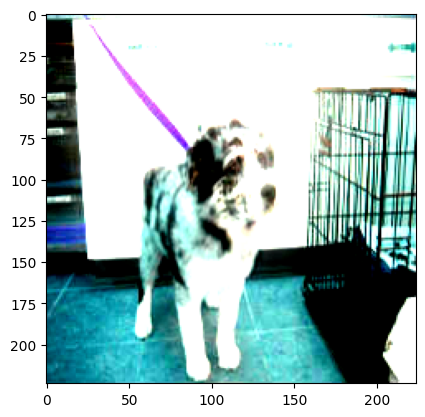

In [30]:
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(),
                                              batchX.max()))
plt.imshow(batchX[0], cmap='gray')


In [13]:
model=Sequential([
    Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])

In [32]:
model_vgg=Sequential([
    VGG16(include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

In [ ]:
train_features.shape

(6395, 128, 128)

In [ ]:
train_labels.shape

(6395, 2)

In [ ]:
test_features.shape

(1599, 128, 128)

In [ ]:
test_labels.shape

(1599, 2)

In [ ]:
# time based early stopping
class LimitTrainingTime(tf.keras.callbacks.Callback):
  def __init__(self, max_time_s):
    super().__init__()
    self.max_time_s = max_time_s
    self.start_time = None

  def on_train_begin(self, logs):
    self.start_time = time.time()

  def on_train_batch_end(self, batch, logs):
    now = time.time()
    if now - self.start_time >  self.max_time_s:
      self.model.stop_training = True


In [39]:
# val loss based early stopping (better)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model.reset_states()
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 128)       15616     
                                                                 
 batch_normalization_15 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 256)       819456    
                                                                 
 batch_normalization_16 (Bat  (None, 15, 15, 256)      1024      
 chNormalization)                                                
                                                      

In [37]:
# history=model.fit(
#     train_features,
#     train_labels,
#     validation_data=(test_features, test_labels),
#     epochs=50,
#     batch_size = BATCH_SIZE,
#     callbacks=[callback]
# )
model_vgg.compile(optimizer=tf.optimizers.SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


In [86]:
# generator
history = model.fit(train_iterator,
          validation_data=test_iterator,
          steps_per_epoch=len(train_iterator),
          epochs = 50,
          callbacks=[callback]
)

Epoch 1/50
200/200 [==============================] - 299s 1s/step - loss: 0.8775 - accuracy: 0.5684 - val_loss: 0.6376 - val_accuracy: 0.6373
Epoch 2/50
 36/200 [====>.........................] - ETA: 3:32 - loss: 0.8520 - accuracy: 0.5651

KeyboardInterrupt: ignored

In [40]:
# generator
history = model_vgg.fit(train_iterator,
          validation_data=test_iterator,
          steps_per_epoch=len(train_iterator),
          epochs = 50,
          callbacks=[callback]
)

Epoch 1/50
 2/50 [>.............................] - ETA: 1:02:33 - loss: 2.1068 - accuracy: 0.5000

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
_, acc = model.evaluate(test_iterator, steps=len(test_iterator))
print('Test Accuracy: %.3f' % (acc * 100))

'''
- accuracy: 72.68% without any preprocessing other than resizing to (64, 64, 3) and normalizing the channels in range [0, 1]
- accuracy: 75.19% with adding vertical reflections in the dataset and normalizing the images in the range [0, 1]
- accuracy: strongest promise with vertical reflections, gray scaling, standardization, and centering
'''